# Linguistic distance
In this notebook, we show how the data from [NGT Signbank](https://signbank.cls.ru.nl/) can be used to compute linguistic distances between signs. We create a matrix-style dataframe where an entry at row R, col C contains the linguistic distance between signs R and C. The distances are computed from the `linguistic_cols`. The variable `unknowns_as_distant` can be set to True to make sure that a comparison between two signs, where an attribute (e.g. Handedness) is unknown for both, should count towards the signs being distant (i.e. distance + 1). 

We also analyze homonyms (signs which look visually similar to a target sign) and minimal pairs (signs which are similar in linguistic attributes to a target sign) and see how they relatively rank in terms of their distance to a target sign. This is done to see if the choice of `unknowns_as_distant` works well. We also plot the distribution of linguistic distances for this same purpose.

Additionally, we keep track of which signs have no known linguistics at all and discard them for the creation of the datasets from Corpus NGT. We do not want to make use of signs for which the linguistics are completely unknown, because distractors (linguistically similar signs) will be difficult to discover for them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import importlib

# Keep python tools up to date
from tools import tools, constants
importlib.reload(tools)
importlib.reload(constants)

# Import all functions from the tools
from tools.tools import*
from tools.constants import PATHS

In [2]:
%%time
# Get signbank dictionary with all known gloss info
sb_df = pd.read_csv(PATHS['signbank_dictionary_info'])
sb_df = sb_df.sort_values(by = 'Signbank ID')

# Decide how to compare two signs if an attribute is unknown for both
# If we set unknowns_as_distant to True, we are more conservative (count them as different)
unknowns_as_distant = False

if unknowns_as_distant:
    sb_df = sb_df.replace(['-'], np.nan)
else: # If unknowns are not distant, allow them to be compared (use some dummy value)
    sb_df = sb_df.fillna('-')

# Store the IDs and names of the sign glosses 
gloss_names = sb_df["Annotation ID Gloss (Dutch)"].values
gloss_ids = sb_df["Signbank ID"].values

# Linguistically relevant columns, except for the first two (which are ID columns)
linguistic_cols = constants.SB_LING_COLS

# Filter for linguistically relevant columns
ling_df = sb_df[linguistic_cols]

# Get the gloss ids and how many there are
ling_np = ling_df.to_numpy()
num = len(gloss_ids)

# Linguistic difference matrix
ling_dist = np.zeros((num, num))

# Loop over the indices of the glosses (signs), and then compare the glosses
for i1 in range(num):
    print('Gloss {}/{}'.format(i1+1, num), end = '\r')
    for i2 in range(i1+1, num):
        gloss1, gloss2 = ling_np[i1], ling_np[i2]
        # Find where the two glosses are dissimilar in their linguistics
        # Skip first 2 distances because the lemma and gloss will naturally be different
        ling_dist[i1, i2] = np.where(~np.equal(gloss1, gloss2))[0].shape[0]-2
        # Distance should be symmetrical
        ling_dist[i2, i1] = ling_dist[i1,i2]

CPU times: total: 30.5 s
Wall time: 30.6 s


In [3]:
# Analyzing the number of missing values for each column except the ID columns
df_with_nans = ling_df.replace(['-'], np.nan).drop(['Signbank ID', 'Annotation ID Gloss (Dutch)'], axis = 1)
# We get percentage values by multiplying by 100 and then dividing by the total number of glosses
missing_series = (df_with_nans.isnull().sum()* 100 / len(df_with_nans)).round(2)
# Convert to a dataframe, and rename the columns to something more informative
missing_df = missing_series.to_frame().reset_index()
missing_df.rename(columns = {'index':'Phonological attribute', 0: 'Missing values'},
          inplace = True)
# Add the percentage symbol to the percentage values
missing_df['Missing values'] = missing_df['Missing values'].apply(lambda x: str(x) + '%')
display(missing_df)

,Phonological attribute,Missing values
0,Handedness,9.95%
1,Strong Hand,10.03%
2,Weak Hand,59.44%
3,Handshape Change,87.26%
4,Relation between Articulators,90.74%
5,Location,15.22%
6,Relative Orientation: Movement,38.42%
7,Relative Orientation: Location,83.72%
8,Orientation Change,87.04%
9,Contact Type,64.78%


In [4]:
print(missing_df.style.to_latex())

\begin{tabular}{lll}
 & Phonological attribute & Missing values \\
0 & Handedness & 9.95% \\
1 & Strong Hand & 10.03% \\
2 & Weak Hand & 59.44% \\
3 & Handshape Change & 87.26% \\
4 & Relation between Articulators & 90.74% \\
5 & Location & 15.22% \\
6 & Relative Orientation: Movement & 38.42% \\
7 & Relative Orientation: Location & 83.72% \\
8 & Orientation Change & 87.04% \\
9 & Contact Type & 64.78% \\
10 & Movement Shape & 89.11% \\
11 & Movement Direction & 44.58% \\
12 & Repeated Movement & 0.0% \\
13 & Alternating Movement & 0.0% \\
\end{tabular}



In [5]:
# Convert to a dataframe where the columns and indices are the gloss names
dist_df = pd.DataFrame(ling_dist, columns=gloss_names, index = gloss_names)
if unknowns_as_distant:
    dist_df.to_csv(PATHS['linguistic_distance_df_v2'])
else:
    dist_df.to_csv(PATHS['linguistic_distance_df'])
# Can convert to numpy by simply doing: 
dist_np = dist_df.to_numpy()

display(dist_df)

,AUKE-KUITERT-B,ABBE-DE-L'EPEE,VERANTWOORDELIJK,JAM-A,LAATSTE-A,LAATSTE-B,VERZEKERING,RIJLES,STATION-B,TROTS-A,...,AANVALLEN-ELKAAR-A,DIALECT-C,POLITIEBUREAU-B,SCHOENMAKER-C,ONBEWUST-A,ONBEWUST-B,X-B,JOEGOSLAVIE-B,HEEL-HOOG,PLUKKEN
AUKE-KUITERT-B,0.0,10.0,9.0,12.0,11.0,11.0,11.0,11.0,10.0,8.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,7.0
ABBE-DE-L'EPEE,10.0,0.0,7.0,10.0,7.0,9.0,8.0,6.0,7.0,8.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,3.0,10.0
VERANTWOORDELIJK,9.0,7.0,0.0,9.0,8.0,8.0,7.0,6.0,7.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,8.0
JAM-A,12.0,10.0,9.0,0.0,10.0,8.0,7.0,10.0,9.0,10.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,11.0
LAATSTE-A,11.0,7.0,8.0,10.0,0.0,6.0,6.0,5.0,6.0,7.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ONBEWUST-B,10.0,6.0,6.0,9.0,6.0,7.0,6.0,5.0,6.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,10.0
X-B,10.0,6.0,6.0,9.0,6.0,7.0,6.0,5.0,6.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,10.0
JOEGOSLAVIE-B,10.0,6.0,6.0,9.0,6.0,7.0,6.0,5.0,6.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,10.0
HEEL-HOOG,10.0,3.0,7.0,9.0,7.0,9.0,8.0,6.0,7.0,8.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,0.0,10.0


In [6]:
# To allow for string comparisons after this, we fill the unknowns with a dummy value here
if unknowns_as_distant:
    sb_df['Relations to other signs'] = sb_df['Relations to other signs'].fillna('-1')
    
# Check only those targets for which at least one related homonym is specified, and get their gloss names
targets = sb_df[sb_df['Relations to other signs'].str.contains('homonym')]['Annotation ID Gloss (Dutch)']
homonym_rankings = []
homonym_dist = []
# Loop over the glosses with homonyms 
for target in targets:
    # Sort the similar signs by distance to the target
    distances = sorted(dist_df[target].sort_values().values.tolist())
    # We first check the column in which homonyms are provided
    homonyms = sb_df[sb_df["Annotation ID Gloss (Dutch)"]==target]['Relations to other signs'].values.tolist()[0]
    # We then filter for values like 'homonym:xxx' where xxx is some signbank ID
    homonyms = re.findall('homonym:\d+', ''.join(homonyms))
    # Of the found homonyms, we only want to keep the xxx ID (not the 'homonym:' prefix), convert them to integer
    homonyms = map(int, re.findall('\d+', ''.join(homonyms)))
    # Find the gloss names corresponding to the signbank IDs
    homonym_glosses = sb_df[sb_df['Signbank ID'].isin(homonyms)]['Annotation ID Gloss (Dutch)'].values.tolist()
    if len(homonym_glosses) == 0:
        continue
    for gloss in homonym_glosses:
        # Store the rank (index) of the homonyms (in terms of its linguistic distance to the target)
        homonym_rankings.append(distances.index(dist_df[target][gloss]))
        homonym_dist.append(dist_df[target][gloss])

In [7]:
# Go over the minimal pairs for each sign and see how they rank in terms of their distance to the target
pairs_df = pd.read_csv(PATHS['signbank_minimal_pairs'])
gloss_col = 'Annotation ID Gloss'
target_col = 'Focus Gloss'

# This part simply translates the minimal pairs DF to Dutch to be consistent with the rest of the datasets
gloss_names = sb_df[["Annotation ID Gloss (Dutch)", "Annotation ID Gloss (English)"]]
gloss_names = gloss_names.rename(columns={gloss_col+' (English)':target_col, gloss_col+' (Dutch)': target_col+' (Dutch)'})
pairs_df = pairs_df.merge(gloss_names, on=target_col)
pairs_col = 'Minimal Pair Gloss'
gloss_names = gloss_names.rename(columns={target_col:pairs_col, target_col+' (Dutch)':pairs_col + ' (Dutch)'})
pairs_df = pairs_df.merge(gloss_names, on='Minimal Pair Gloss')
# We make a column with a list of minimal pairs
pairs_df = pairs_df.groupby([target_col+' (Dutch)'])[pairs_col+' (Dutch)'].apply(list).reset_index()
# Remove any entries where the Dutch minimal pair value is unknown
mask = pairs_df[pairs_col + ' (Dutch)'].apply(lambda x: np.nan in x)
pairs_df = pairs_df[~mask]

# Check only those targets for which at least one related minimal pair is specified
# For minimal pairs we need to convert Focus Gloss and Minimal Pair Gloss to Dutch
minimal_pair_rankings = []
minimal_pair_dist = []

# Loop over the glosses with minimal pairs 
for target in pairs_df[target_col + ' (Dutch)']:
    # Sort the similar signs by distance to the target
    distances = sorted(dist_df[target].sort_values().values.tolist())
    # We first check the column in which minimal pairs are provided
    pairs = pairs_df[pairs_df[target_col + ' (Dutch)']==target][pairs_col+' (Dutch)'].values.tolist()[0]
    for gloss in pairs:
        # Store the rank (index) of the homonyms (in terms of its linguistic distance to the target)        
        minimal_pair_rankings.append(distances.index(dist_df[target][gloss]))
        minimal_pair_dist.append(dist_df[target][gloss])

In [8]:
unknowns_choice = 'counted as distant' if unknowns_as_distant else 'ignored'
print('Homonym linguistic distance (statistics), where unknowns are', unknowns_choice)
print_stats(homonym_dist)
print('-'*60)
print('Minimal linguistic distance (statistics), where unknowns are', unknowns_choice)
print_stats(minimal_pair_dist)

Homonym linguistic distance (statistics), where unknowns are ignored
mean:	0.4	std:	1.16	median:	0.0
------------------------------------------------------------
Minimal linguistic distance (statistics), where unknowns are ignored
mean:	1.02	std:	0.21	median:	1.0


In [9]:
unknowns_choice = 'counted as distant' if unknowns_as_distant else 'ignored'
print('Homonym ranking (statistics), where unknowns are', unknowns_choice)
print_stats(homonym_rankings)
print('-'*60)
print('Minimal pairs ranking (statistics), where unknowns are', unknowns_choice)
print_stats(minimal_pair_rankings)

Homonym ranking (statistics), where unknowns are ignored
mean:	27.88	std:	239.8	median:	0.0
------------------------------------------------------------
Minimal pairs ranking (statistics), where unknowns are ignored
mean:	2.75	std:	36.54	median:	1.0


In [10]:
# remove columns which are never empty
cols_remove = ["Signbank ID", "Annotation ID Gloss (Dutch)"]
ling_df_no_names = ling_df.drop(columns=cols_remove)

# Set all values which are left unspecified (either -1 or '-') to NaN 
ling_df_no_names = ling_df_no_names.replace('-', np.NaN)
ling_df_no_names = ling_df_no_names.replace(-1, np.NaN)

# get the rows where no annotations exist whatsoever
empty_rows = np.where(ling_df_no_names.iloc[:, :-2].isnull().all(1) & (~ling_df_no_names.iloc[:, -2:]).all(1))[0]

# read the columns we wanted to ignore (gloss name and ID are never empty)
for col in cols_remove:
    ling_df_no_names[col] = ling_df[col]
# remove the non-annotated rows
ling_df_no_names = ling_df_no_names.drop(empty_rows, axis=0)
sb_df_with_linguistics = sb_df[sb_df['Signbank ID'].isin(ling_df_no_names['Signbank ID'].values.tolist())]
# keep only those signs which have known linguistics
sb_df_with_linguistics.to_csv(PATHS['signbank_with_linguistics'])

In [11]:
label_glosses = np.load(PATHS['top_signs'].format('-1'))
remaining_glosses = ling_df_no_names['Annotation ID Gloss (Dutch)'].values.tolist()
num_no_linguistics = len(set(label_glosses)- set(remaining_glosses))
print('Num. signs in the Corpus for which no linguistics are provided:', num_no_linguistics)

Num. signs in the Corpus for which no linguistics are provided: 313


In [12]:
# An example to find the signs at a specific distance from a target sign
target = 'PT-1hand:1'
distance = 1
print(sorted(dist_df[dist_df[target]==distance][target].index))

['ARM-A', 'BEEN-A', 'BUIK', 'DOOF-A', 'GERAAKT-A', 'HELPEN-C', 'IN-B', 'KNIE', 'KRIJGEN-C', 'MAAND-B', 'NEUS', 'OOG', 'OOR', 'PT-Bhand:1', 'RUIKEN', 'SCHOUDER', 'STEM-A', 'TAND', 'VERLEGEN-A', 'WETEN-A', 'WIT']


In [13]:
print('Linguistic distance (statistics), where unknowns are', unknowns_choice)
print_stats(dist_np)

Linguistic distance (statistics), where unknowns are ignored
mean:	6.81	std:	1.92	median:	7.0


(8646561,)


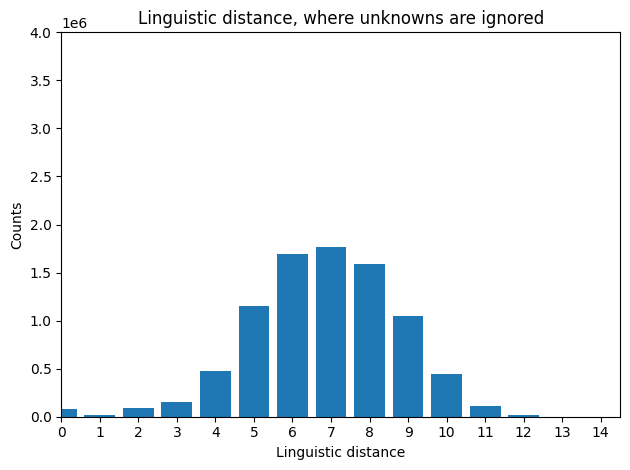

CPU times: total: 750 ms
Wall time: 777 ms


In [14]:
%%time
# Histogram of the linguistic distances
# We ignore the diagonal because the distance of a sign with itself is always 0
# And we only need to take the upper triangle because the distances are symmetrical (dist(a,b) = dist(b,a))
def upper_tri_indexing(arr):
    m = arr.shape[0]
    r,c = np.triu_indices(m,1)
    return arr[r,c]
n = dist_np.shape[0]
row, col = np.triu_indices(n,1)
dist_np_upper_tri = dist_np[row, col]
print(dist_np_upper_tri.shape)
# plt.hist(dist_np_upper_tri, bins = 15)
labels, counts = np.unique(dist_np_upper_tri, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xlabel('Linguistic distance')
plt.xlim(0,14.5)
plt.xticks(range(15))
plt.ylabel('Counts')
plt.ylim(0, 4e6)
plt.title('Linguistic distance, where unknowns are ' + unknowns_choice)
plt.tight_layout()

path =  'counting_unknowns' if unknowns_as_distant else 'ignoring_unknowns'
plt.savefig('./results/ling_dist_hist_{}.png'.format(path))
plt.show()

In [15]:
# Comparing the homonyms and minimal pairs for each target sign
# We ignore any signs for which either the homonyms or minimal pairs are not known
# Load minimal pairs dictionary
pairs_df = pd.read_csv(PATHS['signbank_minimal_pairs'])

# To allow for string comparisons after this, we fill the unknowns with a dummy value here
if unknowns_as_distant:
    sb_df['Relations to other signs'] = sb_df['Relations to other signs'].fillna('-1')
    
# Check only those targets for which at least one related homonym is specified, and get their gloss names
targets = sb_df[sb_df['Relations to other signs'].str.contains('homonym')]['Annotation ID Gloss (English)']
homonym_rankings = []
# Loop over a few of the glosses with homonyms 
for target in targets.iloc[:5]:
    # We first check the column in which homonyms are provided
    homonyms = sb_df[sb_df["Annotation ID Gloss (English)"]==target]['Relations to other signs'].values.tolist()[0]
    # We then filter for values like 'homonym:xxx' where xxx is some signbank ID
    homonyms = re.findall('homonym:\d+', ''.join(homonyms))
    # Of the found homonyms, we only want to keep the xxx ID (not the 'homonym:' prefix), convert them to integer
    homonyms = map(int, re.findall('\d+', ''.join(homonyms)))
    # Find the gloss names corresponding to the signbank IDs
    homonym_glosses = sb_df[sb_df['Signbank ID'].isin(homonyms)]['Annotation ID Gloss (English)'].values.tolist()
    
    minimal_pairs = pairs_df[pairs_df['Focus Gloss']==target]['Minimal Pair Gloss'].values.tolist()
    # Only compare if minimal pairs are also known
    if np.nan not in minimal_pairs:
        print('Target sign', target)
        print('Minimal pairs', sorted(minimal_pairs))
        print('Homonyms', sorted(homonym_glosses))
        print('--------------')

Target sign BRAINS-B
Minimal pairs ['PUNK']
Homonyms ['BALD-HEADED']
--------------
